# HW7: Neural Net Performance on Phoneme Data for Speech Recognition 

Blanca Miller <br />
STAT 760 <br />
04.05.2018 <br />

__Objective:__ The aim of neural networks is to extract linear combinations of inputs as derived features to generate a nonlinear model of the data that makes predictions for new data sets [1]. A neural net takes a set of inputs, weights and biases them, and runs them through a series of hidden layers. These hidden layers are composed of nodes that each contain primitive function; nodes add together the weighted inputs it retrieves and applies the primitive function, an activation function that is usually the sigmoid activation function [2]. After traversing the network of hidden layers, the inputs are transformed into a set of outputs to make predictions about new data [1]. When given a set of data with known labels/targets estimating the optimal neural network weights and biases is computed using back-propogation. For this assignment, a data set of 5 phoneme classifications from continuous data of 50 male speakers were used.

Sigmoid Function: sigmoid σ(v) = 1/(1 + e^(−v))

__Data Set__
- 4509 speech frames 
- Each speech frame has a 32ms duration
- ~2 examples for each phoneme from each speaker were chosen
- Each speech frame is represented by 512 samples at 16kHz sampling rate
- 5 phonemes of 4509 speech frames, frequencies & sounds:
        - aa: 695 as in "dark" vowel,
        - ao: 1022 as the first vowel in "water", 
        - dcl: 757 as in "dark",
        - iy: 1163 as in "she" vowel, & 
        - sh: 872 as in "she"
        
- x.1 - x.256: 256 data columns 
- g: response column
- speaker: speaker identification

__References__
1. Trevor Hastie, Robert Tibshirani, Jerome Friedman, Elements of Statistical Learning: Data mining, inference, and prediction, 2002. Retrieved from: http://web.stanford.edu/~hastie/ElemStatLearn/main.html
2. Raul Rojas, Neural Networks: A systematic introduction, 1996. Retrieved from: http://page.mi.fu-berlin.de/rojas/neural/neuron.pdf

__Phoneme Data Set:__ http://web.stanford.edu/~hastie/ElemStatLearn/

### Import Libraries

In [1]:
import sklearn 
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

### Function: Confusion Matrix

In [2]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Load Phoneme Digits Data Set Into a DataFrame

In [3]:
data = pd.read_csv('five_phonemes.txt', sep=',')

In [4]:
data.shape

(4509, 259)

In [5]:
print(data[0:10])

   row.names       x.1       x.2       x.3       x.4       x.5       x.6  \
0          1   9.85770   9.20711   9.81689   9.01692   9.05675   8.92518   
1          2  13.23079  14.19189  15.34428  18.11737  19.53875  18.32726   
2          3  10.81889   9.07615   9.77940  12.20135  12.59005  10.53364   
3          4  10.53679   9.12147  10.84621  13.92331  13.52476  10.27831   
4          5  12.96705  13.69454  14.91182  18.22292  18.45390  17.25760   
5          6  11.66525  12.43949  14.74297  18.83307  18.55868  14.86749   
6          7  10.95324  11.20585  16.17634  18.59300  17.50922  10.27798   
7          8  15.58114  15.53505  13.83707  13.89967  14.59198  14.05211   
8          9   9.37324  11.29505  17.15139  18.03336  14.95980  14.97031   
9         10   9.48477  11.38758  16.74884  17.36141  14.67661  15.02621   

        x.7       x.8       x.9         ...              x.249     x.250  \
0  11.28308  11.52980  10.79713         ...           12.68076  11.20767   
1  17.34169

### Convert Data Frame Into Numpy Array

In [6]:
data_set = data.as_matrix()

In [7]:
print(data[0:10])

   row.names       x.1       x.2       x.3       x.4       x.5       x.6  \
0          1   9.85770   9.20711   9.81689   9.01692   9.05675   8.92518   
1          2  13.23079  14.19189  15.34428  18.11737  19.53875  18.32726   
2          3  10.81889   9.07615   9.77940  12.20135  12.59005  10.53364   
3          4  10.53679   9.12147  10.84621  13.92331  13.52476  10.27831   
4          5  12.96705  13.69454  14.91182  18.22292  18.45390  17.25760   
5          6  11.66525  12.43949  14.74297  18.83307  18.55868  14.86749   
6          7  10.95324  11.20585  16.17634  18.59300  17.50922  10.27798   
7          8  15.58114  15.53505  13.83707  13.89967  14.59198  14.05211   
8          9   9.37324  11.29505  17.15139  18.03336  14.95980  14.97031   
9         10   9.48477  11.38758  16.74884  17.36141  14.67661  15.02621   

        x.7       x.8       x.9         ...              x.249     x.250  \
0  11.28308  11.52980  10.79713         ...           12.68076  11.20767   
1  17.34169

### Parse Data Set

In [8]:
# Parse data values: get columns 1-(last-1) for all rows
X_phonemes = data_set[1:4509, 1:257]

# Parse labels: get last column for all rows 
y_phonemes = data_set[1:4509, 257]

In [9]:
print("Data: {}".format(X_phonemes.shape))
print("Labels: {}".format(y_phonemes.shape))

Data: (4508, 256)
Labels: (4508,)


In [10]:
print(X_phonemes[0:4])

[[13.230789999999999 14.191889999999999 15.34428 ... 5.38504 9.43063
  8.59328]
 [10.81889 9.07615 9.7794 ... 6.584160000000001 6.270580000000001
  3.8504199999999997]
 [10.53679 9.12147 10.846210000000001 ... 3.63384 3.22823 4.63123]
 [12.96705 13.69454 14.91182 ... 7.036 7.01278 8.52197]]


In [11]:
print(y_phonemes[0:4])

['iy' 'dcl' 'dcl' 'aa']


### Generate Test & Training Set

In [12]:
# Allocate 2/3 of the data set as training & 1/3 as testing
X_train, X_test, y_train, y_test = train_test_split(X_phonemes, y_phonemes, test_size=0.33)

In [13]:
# print data & label set dimensionality for verification
print("Phoneme Training Data: {}".format(X_train.shape))
print("Phoneme Training Labels: {}".format(y_train.shape))
print("Phoneme Testing Data: {}".format(X_test.shape))
print("Phoneme Testing Labels: {}".format(y_test.shape))

Phoneme Training Data: (3020, 256)
Phoneme Training Labels: (3020,)
Phoneme Testing Data: (1488, 256)
Phoneme Testing Labels: (1488,)


In [14]:
print(X_train[0:4])

[[13.05684 12.15286 11.68652 ... 16.33494 17.721510000000002 17.58149]
 [12.79842 13.476720000000002 17.40405 ... 11.32956 11.33175
  9.428510000000001]
 [12.90393 17.1588 17.64408 ... 5.96785 9.287939999999999 9.35458]
 [10.35282 13.7709 18.31685 ... 10.02208 8.59123 9.48892]]


In [15]:
print(X_test[0:4])

[[12.19802 13.341029999999998 17.20662 ... 12.59448 10.3658
  10.300839999999999]
 [12.72964 14.392 17.68615 ... 7.12197 7.41153 -0.98787]
 [11.15903 10.06408 10.19806 ... 12.67309 12.09459 12.83682]
 [1.93104 9.06493 16.97346 ... 10.913089999999999 10.298789999999999
  7.89146]]


### Standardize Data to Obtain Similar Inputs & Weight Magnitudes

In [16]:
# set axis to 1 to standardize by sample/vector, rather than by feature 
X_train = preprocessing.scale(X_train, axis=1)
X_test = preprocessing.scale(X_test, axis=1)

/home/blanca/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


### Principal Componenet Analysis: 
Identify the main uncorrelated variables to re-express noisy data in a simplified way

In [17]:
k = 8
pca = decomposition.PCA(n_components = k)
pca.fit(X_train)
X_train_trans = pca.transform(X_train)
X_test_trans = pca.transform(X_test)

k70 = 23
pca70 = decomposition.PCA(n_components = k70)
pca70.fit(X_train)
X_train_trans70 = pca70.transform(X_train)
X_test_trans70 = pca70.transform(X_test)

In [18]:
X_test_trans.shape

(1488, 8)

In [19]:
# amount of information compressed in the chosen k components
pca.explained_variance_ratio_

array([0.33126052, 0.08328629, 0.07200415, 0.03627051, 0.02452778,
       0.0226794 , 0.01488401, 0.01310095])

In [20]:
pca.explained_variance_ratio_.sum()

0.5980136041636218

In [21]:
pca70.explained_variance_ratio_.sum()

0.6972704601798367

(0, 60)

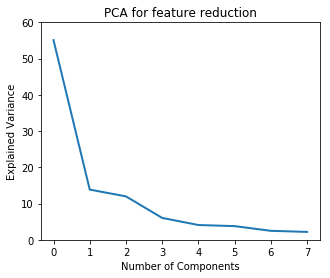

In [22]:
plt.figure(1, figsize=(5,4))      # create a figure instance
plt.clf()                         # clear the current figure
plt.axes                          # set the coordinate system
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.title('PCA for feature reduction')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.ylim(0,60)

__Analysis:__ The cumulative variance for 8 principal components is ~60% and ~70% for 23 principal components. It is generally recommended to only remove ~30% of the information contained in the original components, however in this case it may be preferred to remove more of the information as the cost of obtaining more accuracy means trippling the number of features.

In [23]:
# print data & label set dimensionality for verification
print("Training Data: {}".format(X_train_trans.shape))
print("Training Labels: {}\n".format(y_train.shape))
print("Testing Data: {}".format(X_test_trans.shape))
print("Testing Labels: {}".format(y_test.shape))

Training Data: (3020, 8)
Training Labels: (3020,)

Testing Data: (1488, 8)
Testing Labels: (1488,)


In [24]:
print(X_train_trans[0:4])

[[14.40650708  0.19594241 -0.85555143  1.96433675  3.19321295 -2.26494736
  -1.7069648   1.12346677]
 [-5.52868488  0.68814618 -3.12707982  0.50704173  0.74588287 -2.86987777
   1.09387758  3.05159342]
 [-6.64502061 -1.25314912 -0.95701664  3.58666307  2.63493474 -1.13569019
  -0.2299971  -1.48225359]
 [-7.2105206   2.27645948 -3.79946042 -0.64261324  2.12512275 -0.50668044
   0.16401159  1.48612208]]


In [25]:
print(y_train[0:4])

['sh' 'aa' 'aa' 'ao']


### Train a 1 Hidden Layer Neural Net for 10 & 100 nodes
Use MLP to Train with Backpropagation

In [26]:
# initialize classifier model objects
clf_10 = MLPClassifier(hidden_layer_sizes=(10,))
clf_100 = MLPClassifier()
clf_199 = MLPClassifier()

In [27]:
# fit the generated classifier models to the data matrix X and its targets y
clf_10.fit(X_train_trans, y_train)
clf_100.fit(X_train_trans, y_train)
clf_199.fit(X_train_trans, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

#### Determine the Neural Nets Predictive Score

In [28]:
print("SET SCORES FOR 1 HIDDEN LAYER & 10 NODES")
print("Training set score: %f" % clf_10.score(X_train_trans, y_train))
print("Test set score: %f \n" % clf_10.score(X_test_trans, y_test))
print("SET SCORES FOR 1 HIDDEN LAYER & 100 NODES")
print("Training set score: %f" % clf_100.score(X_train_trans, y_train))
print("Test set score: %f \n" % clf_100.score(X_test_trans, y_test))
print("SET SCORES FOR 1 HIDDEN LAYER & 199 NODES")
print("Training set score: %f" % clf_199.score(X_train_trans, y_train))
print("Test set score: %f" % clf_199.score(X_test_trans, y_test))

SET SCORES FOR 1 HIDDEN LAYER & 10 NODES
Training set score: 0.907616
Test set score: 0.897849 

SET SCORES FOR 1 HIDDEN LAYER & 100 NODES
Training set score: 0.924172
Test set score: 0.895161 

SET SCORES FOR 1 HIDDEN LAYER & 199 NODES
Training set score: 0.920530
Test set score: 0.893145


#### Predict Labels for New Data

In [29]:
test_predictions_10 = clf_10.predict(X_test_trans)
test_predictions_100 = clf_100.predict(X_test_trans)
test_predictions_199 = clf_199.predict(X_test_trans)

In [30]:
cm_10 = confusion_matrix(y_test, test_predictions_10)
cm_100 = confusion_matrix(y_test, test_predictions_100)
cm_199 = confusion_matrix(y_test, test_predictions_199)

In [31]:
print("Dimensions for 10 nodes: {}".format(cm_10.shape))
print("Dimensions for 100 nodes: {}".format(cm_100.shape))
print("Dimensions for 199 nodes: {}".format(cm_199.shape))

Dimensions for 10 nodes: (5, 5)
Dimensions for 100 nodes: (5, 5)
Dimensions for 199 nodes: (5, 5)


#### Generate Confusion Matrices

In [32]:
class_names = ['aa','ao','dcl','iy','sh']

Confusion matrix, without normalization
[[167  60   0   0   0]
 [ 58 291   1   0   0]
 [  1   1 212  15   0]
 [  0   0  14 362   1]
 [  1   0   0   0 304]]


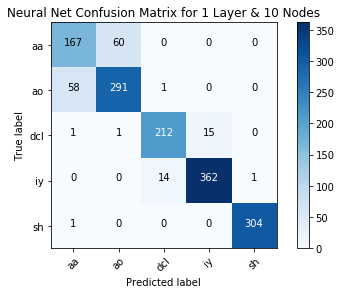

In [33]:
plot_confusion_matrix(cm_10, classes=class_names, title='Neural Net Confusion Matrix for 1 Layer & 10 Nodes')

Confusion matrix, without normalization
[[151  76   0   0   0]
 [ 48 301   0   1   0]
 [  1   0 211  17   0]
 [  0   0  14 362   1]
 [  1   0   0   0 304]]


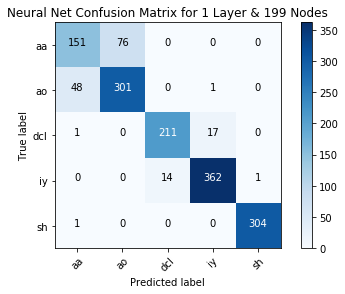

In [34]:
plot_confusion_matrix(cm_199, classes=class_names, title='Neural Net Confusion Matrix for 1 Layer & 199 Nodes')

### Train a 10 Hidden Layer Neural Net
Use MLP to Train Using Backpropagation

In [35]:
# initialize classifier model objects 
clf_10_10 = MLPClassifier(hidden_layer_sizes=(10,10)) 
clf_10_100 = MLPClassifier(hidden_layer_sizes=(100,10))
clf_10_199 = MLPClassifier(hidden_layer_sizes=(199,10))

In [36]:
# fit the generated classifier models to the data matrix X and its targets y
clf_10_10.fit(X_train_trans, y_train)
clf_10_100.fit(X_train_trans, y_train)
clf_10_199.fit(X_train_trans, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(199, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

#### Determine the Neural Nets Predictive Scores

In [37]:
print("SET SCORES FOR 10 HIDDEN LAYER & 10 NODES")
print("Training set score: %f" % clf_10_10.score(X_train_trans, y_train))
print("Test set score: %f \n" % clf_10_10.score(X_test_trans, y_test))

print("SET SCORES FOR 10 HIDDEN LAYER & 100 NODES")
print("Training set score: %f" % clf_10_100.score(X_train_trans, y_train))
print("Test set score: %f \n" % clf_10_100.score(X_test_trans, y_test))

print("SET SCORES FOR 10 HIDDEN LAYER & 199 NODES")
print("Training set score: %f" % clf_10_199.score(X_train_trans, y_train))
print("Test set score: %f" % clf_10_199.score(X_test_trans, y_test))

SET SCORES FOR 10 HIDDEN LAYER & 10 NODES
Training set score: 0.900000
Test set score: 0.887769 

SET SCORES FOR 10 HIDDEN LAYER & 100 NODES
Training set score: 0.918212
Test set score: 0.890457 

SET SCORES FOR 10 HIDDEN LAYER & 199 NODES
Training set score: 0.919868
Test set score: 0.893145


#### Predict Labels for New Data

In [38]:
test_predictions_10_10 = clf_10_10.predict(X_test_trans)
test_predictions_10_100 = clf_10_100.predict(X_test_trans)
test_predictions_10_199 = clf_10_199.predict(X_test_trans)

In [39]:
cm_10_10 = confusion_matrix(y_test, test_predictions_10_10)
cm_10_100 = confusion_matrix(y_test, test_predictions_10_100)
cm_10_199 = confusion_matrix(y_test, test_predictions_10_199)

#### Generate Confusion Matrices

Confusion matrix, without normalization
[[163  64   0   0   0]
 [ 64 285   1   0   0]
 [  1   1 210  17   0]
 [  0   0  16 360   1]
 [  1   0   1   0 303]]


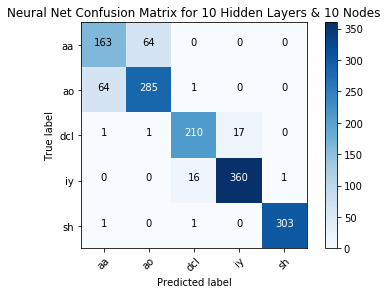

In [40]:
plot_confusion_matrix(cm_10_10, classes=class_names, title='Neural Net Confusion Matrix for 10 Hidden Layers & 10 Nodes')

Confusion matrix, without normalization
[[160  67   0   0   0]
 [ 58 292   0   0   0]
 [  1   0 213  14   1]
 [  0   0  16 360   1]
 [  1   0   0   0 304]]


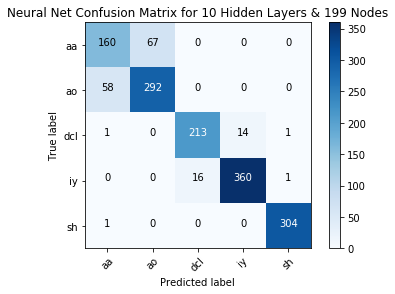

In [41]:
plot_confusion_matrix(cm_10_199, classes=class_names, title='Neural Net Confusion Matrix for 10 Hidden Layers & 199 Nodes')

### Train a 50 Hidden Layer Neural Net
Use MLP to Train Using Backpropagation

In [42]:
# initialize classifier model objects 
clf_50_10 = MLPClassifier(hidden_layer_sizes=(10,50)) 
clf_50_100 = MLPClassifier(hidden_layer_sizes=(100,50))
clf_50_199 = MLPClassifier(hidden_layer_sizes=(199,50))

In [43]:
# fit the generated classifier models to the data matrix X and its targets y
clf_50_10.fit(X_train_trans, y_train)
clf_50_100.fit(X_train_trans, y_train)
clf_50_199.fit(X_train_trans, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(199, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

#### Determine the Neural Nets Predictive Scores

In [44]:
print("SET SCORES FOR 50 HIDDEN LAYER & 10 NODES")
print("Training set score: %f" % clf_50_10.score(X_train_trans, y_train))
print("Test set score: %f \n" % clf_50_10.score(X_test_trans, y_test))

print("SET SCORES FOR 50 HIDDEN LAYER & 100 NODES")
print("Training set score: %f" % clf_50_100.score(X_train_trans, y_train))
print("Test set score: %f \n" % clf_50_100.score(X_test_trans, y_test))

print("SET SCORES FOR 50 HIDDEN LAYER & 199 NODES")
print("Training set score: %f" % clf_50_199.score(X_train_trans, y_train))
print("Test set score: %f" % clf_50_199.score(X_test_trans, y_test))

SET SCORES FOR 50 HIDDEN LAYER & 10 NODES
Training set score: 0.909272
Test set score: 0.885753 

SET SCORES FOR 50 HIDDEN LAYER & 100 NODES
Training set score: 0.918874
Test set score: 0.887097 

SET SCORES FOR 50 HIDDEN LAYER & 199 NODES
Training set score: 0.925828
Test set score: 0.895833


#### Predict Labels for New Data

In [45]:
test_predictions_50_10 = clf_50_10.predict(X_test_trans)
test_predictions_50_100 = clf_50_100.predict(X_test_trans)
test_predictions_50_199 = clf_50_199.predict(X_test_trans)

In [46]:
cm_50_10 = confusion_matrix(y_test, test_predictions_50_10)
cm_50_100 = confusion_matrix(y_test, test_predictions_50_100)
cm_50_199 = confusion_matrix(y_test, test_predictions_50_199)

#### Generate Confusion Matrices

Confusion matrix, without normalization
[[158  69   0   0   0]
 [ 58 292   0   0   0]
 [  2   1 211  13   2]
 [  0   0  21 355   1]
 [  1   0   0   2 302]]


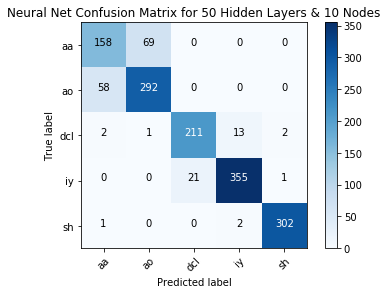

In [47]:
plot_confusion_matrix(cm_50_10, classes=class_names, title='Neural Net Confusion Matrix for 50 Hidden Layers & 10 Nodes')

Confusion matrix, without normalization
[[171  56   0   0   0]
 [ 67 283   0   0   0]
 [  1   0 212  16   0]
 [  0   0  13 363   1]
 [  1   0   0   0 304]]


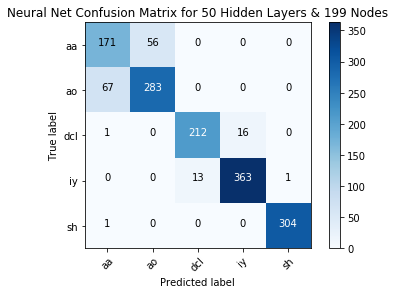

In [48]:
plot_confusion_matrix(cm_50_199, classes=class_names, title='Neural Net Confusion Matrix for 50 Hidden Layers & 199 Nodes')

__Analysis:__ The overall performance of using a neural net to classify phonemes is significantly reliable as it was ~90% for all three cases of layer & node architectures. One interesting result is that the 1 hidden layer & 10 node architecture had higher predictive accuracy that the 10 hidden layer architectures for the first phoneme, aa, while the 1 hidden layer & 199 nodes architecture made 15-20 more misclassifications. Morevoer, the remaining 4 phonemes saw similar accuracy across the three architectures. It would be necessary to compute an average for the architectures to determine a more realistic value of accuracy, however, it is safe to say that the higher layer count increased the predicitive accuracy for the classifiers. 